In [7]:
!pip install kaggle --quiet

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lainguyn123/student-performance-factors
!unzip -o student-performance-factors.zip



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors
License(s): CC0-1.0
student-performance-factors.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  student-performance-factors.zip
  inflating: StudentPerformanceFactors.csv  


In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid", palette="muted", font_scale=1.2)


df = pd.read_csv("StudentPerformanceFactors.csv")

print("Dataset Shape:", df.shape)
display(df.head())



df.drop_duplicates(inplace=True)

df['Hours_Studied'] = pd.to_numeric(df['Hours_Studied'], errors='coerce')
df['Exam_Score'] = pd.to_numeric(df['Exam_Score'], errors='coerce')

df.dropna(subset=['Hours_Studied', 'Exam_Score'], inplace=True)

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)



Dataset Shape: (6607, 20)


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


/tmp/ipython-input-1380073418.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-1380073418.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

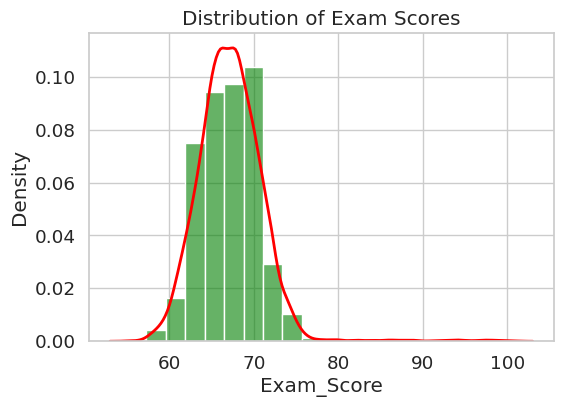

In [31]:
plt.figure(figsize=(6, 4))
sns.histplot(df['Exam_Score'], bins=20, color="green", stat="density", alpha=0.6)
sns.kdeplot(df['Exam_Score'], color="red", linewidth=2)
plt.title("Distribution of Exam Scores")
plt.show()


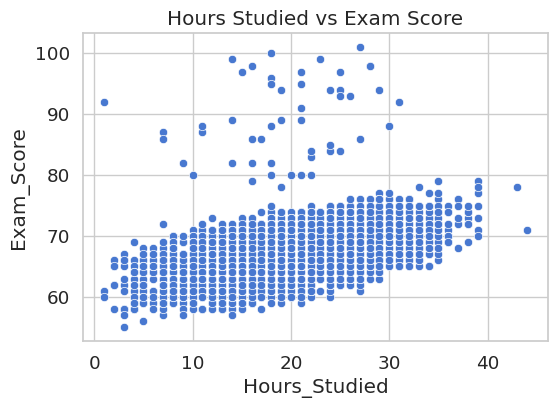

In [10]:

plt.figure(figsize=(6, 4))
sns.scatterplot(x='Hours_Studied', y='Exam_Score', data=df)
plt.title("Hours Studied vs Exam Score")
plt.show()



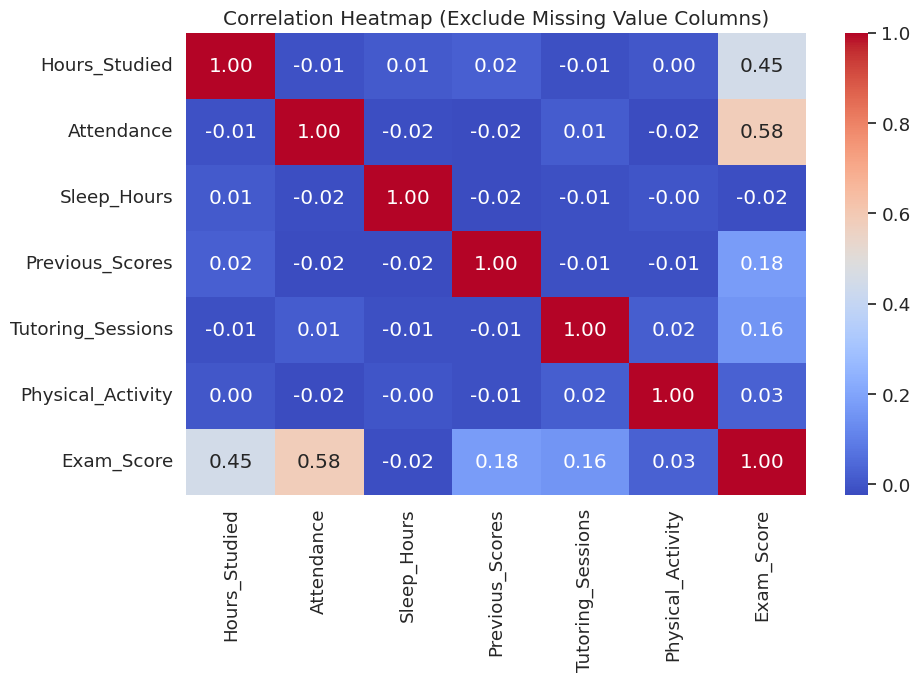

In [11]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols = [col for col in numeric_cols if df[col].isnull().sum() == 0]

plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Exclude Missing Value Columns)")
plt.show()


In [12]:


X = df[['Hours_Studied']]
y = df['Exam_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

lin_metrics = {
    "Model": "Linear (Hours_Studied)",
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "R²": r2_score(y_test, y_pred)
}


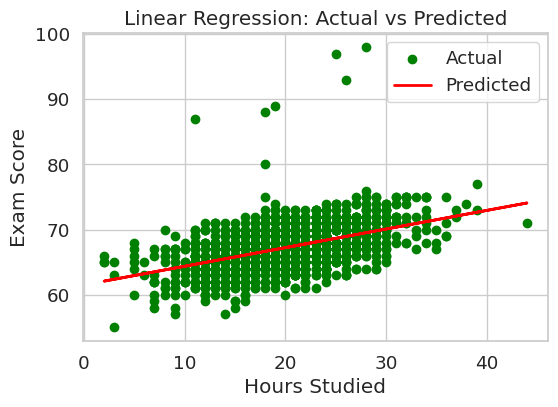

In [27]:

plt.figure(figsize=(6, 4))
plt.scatter(X_test, y_test, color='green', label="Actual")
plt.plot(X_test, y_pred, color='red', linewidth=2, label="Predicted")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Linear Regression: Actual vs Predicted")
plt.legend()
plt.show()



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


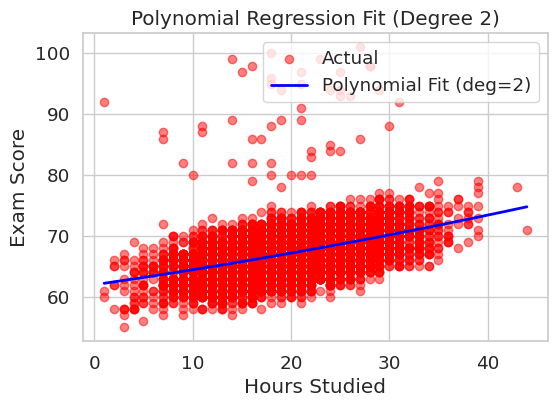

In [26]:



def polynomial_regression(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
        X_poly, y, test_size=0.2, random_state=42
    )

    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train_poly)

    y_poly_pred = poly_reg.predict(X_test_poly)

    metrics = {
        "Model": f"Polynomial (deg={degree})",
        "MAE": mean_absolute_error(y_test_poly, y_poly_pred),
        "MSE": mean_squared_error(y_test_poly, y_poly_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test_poly, y_poly_pred)),
        "R²": r2_score(y_test_poly, y_poly_pred)
    }

    if degree == 2:
        X_seq = np.linspace(min(X['Hours_Studied']), max(X['Hours_Studied']), 300).reshape(-1, 1)
        y_seq_pred = poly_reg.predict(poly.transform(X_seq))

        plt.figure(figsize=(6, 4))
        plt.scatter(X, y, color="red", alpha=0.5, label="Actual")
        plt.plot(X_seq, y_seq_pred, color="blue", linewidth=2, label="Polynomial Fit (deg=2)")
        plt.xlabel("Hours Studied")
        plt.ylabel("Exam Score")
        plt.title("Polynomial Regression Fit (Degree 2)")
        plt.legend()
        plt.show()

    return metrics


poly2_metrics = polynomial_regression(degree=2)
poly3_metrics = polynomial_regression(degree=3)




In [19]:


extra_features = ['Hours_Studied', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level']

df_encoded = pd.get_dummies(df[extra_features], drop_first=True)

X_extra = df_encoded
y = df['Exam_Score']

X_train_extra, X_test_extra, y_train_extra, y_test_extra = train_test_split(
    X_extra, y, test_size=0.2, random_state=42
)

lin_reg_extra = LinearRegression()
lin_reg_extra.fit(X_train_extra, y_train_extra)

y_extra_pred = lin_reg_extra.predict(X_test_extra)

multi_metrics = {
    "Model": "Multi-feature",
    "MAE": mean_absolute_error(y_test_extra, y_extra_pred),
    "MSE": mean_squared_error(y_test_extra, y_extra_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test_extra, y_extra_pred)),
    "R²": r2_score(y_test_extra, y_extra_pred)
}



results = pd.DataFrame([lin_metrics, poly2_metrics, poly3_metrics, multi_metrics])
print("\nModel Comparison:\n")
display(results)




Model Comparison:



,Model,MAE,MSE,RMSE,R²
0,Linear (Hours_Studied),2.447569,10.855921,3.294833,0.231987
1,Polynomial (deg=2),2.444780,10.844988,3.293173,0.232760
2,Polynomial (deg=3),2.444512,10.843834,3.292998,0.232842
3,Multi-feature,2.389999,10.368509,3.220017,0.266469


In [20]:


coeffs = pd.DataFrame({
    "Feature": X_extra.columns,
    "Coefficient": lin_reg_extra.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Multi-feature Linear Regression):\n")
display(coeffs)



Feature Importance (Multi-feature Linear Regression):



,Feature,Coefficient
0,Hours_Studied,0.285363
2,Previous_Scores,0.045315
1,Sleep_Hours,-0.080570
4,Motivation_Level_Medium,-0.406981
3,Motivation_Level_Low,-0.904084


/tmp/ipython-input-1555846428.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coeffs, palette="coolwarm")


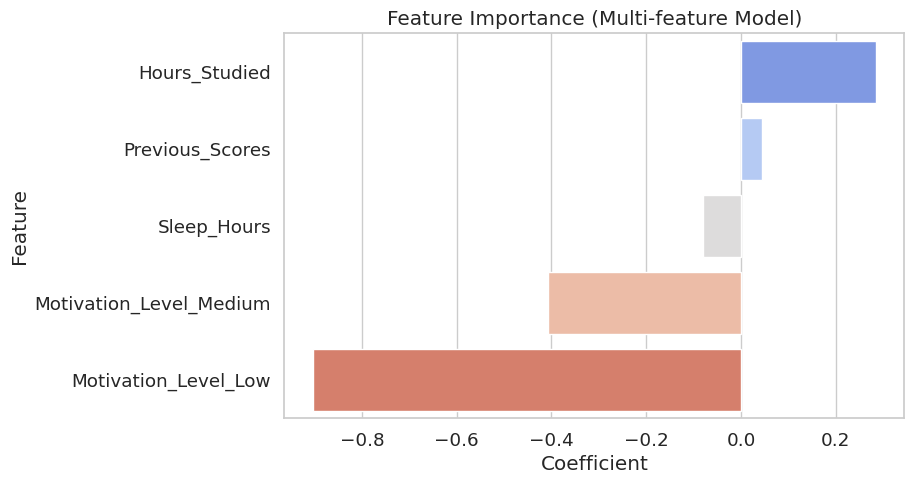

In [21]:

plt.figure(figsize=(8, 5))
sns.barplot(x="Coefficient", y="Feature", data=coeffs, palette="coolwarm")
plt.title("Feature Importance (Multi-feature Model)")
plt.show()

In [22]:

best_model_idx = results['R²'].idxmax()
best_model = results.loc[best_model_idx]

print("=== Model Comparison Table ===")
display(results)

print("\n=== Best Model Based on R² ===")
print(f"Model: {best_model['Model']}")
print(f"R² Score: {best_model['R²']:.3f}")
print(f"RMSE: {best_model['RMSE']:.3f}")
print(f"MAE: {best_model['MAE']:.3f}")

print("\nInterpretation:")
print("A higher R² and lower RMSE/MAE indicate better performance.")
print("Comparing results, the model above performed best at predicting exam scores.")




=== Model Comparison Table ===


,Model,MAE,MSE,RMSE,R²
0,Linear (Hours_Studied),2.447569,10.855921,3.294833,0.231987
1,Polynomial (deg=2),2.444780,10.844988,3.293173,0.232760
2,Polynomial (deg=3),2.444512,10.843834,3.292998,0.232842
3,Multi-feature,2.389999,10.368509,3.220017,0.266469



=== Best Model Based on R² ===
Model: Multi-feature
R² Score: 0.266
RMSE: 3.220
MAE: 2.390

Interpretation:
A higher R² and lower RMSE/MAE indicate better performance.
Comparing results, the model above performed best at predicting exam scores.


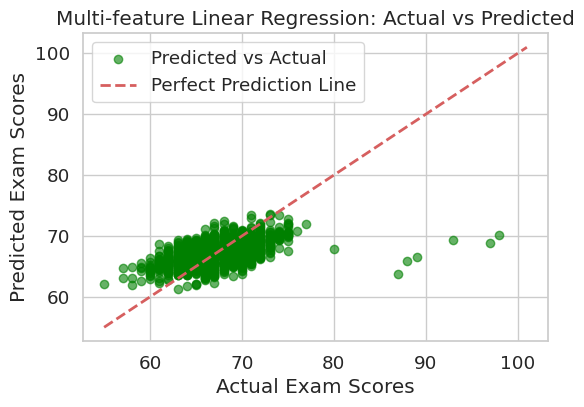

In [25]:

plt.figure(figsize=(6, 4))
plt.scatter(y_test_extra, y_extra_pred, alpha=0.6, color="green", label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label="Perfect Prediction Line")
plt.xlabel("Actual Exam Scores")
plt.ylabel("Predicted Exam Scores")
plt.title("Multi-feature Linear Regression: Actual vs Predicted")
plt.legend()
plt.show()
